# Simulation Molecular Traffic Jam

Simulation of traffic jam formation with molecular motors on a microtubule based on the Gillespie algorithm. 

<img src="Fig_model.png" alt="Drawing" style="width: 1000px;"/>

Relevant publications:
* Cho et al. (2008). "Regulatory ATPase sites of cytoplasmic dynein affect processivity and force generation". JBC 283(38): 25839-25845
* Leduc et al. (2012). "Molecular crowding creates traffic jams of kinesin motors on microtubules". PNAS 109(16): 6100-6105
* Parmeggiani et al. (2004). "Totally assymetric simple exclusion process with Langmuir kinetics". Phys Rev Lett 70: 046101



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import sys
import os
from datetime import date, datetime
from time import strftime
from parameters import ParameterSet
from IPython.display import clear_output

## Define simulation parameters


In [2]:
# Dictionary to store all simulation parameters
simParameters = {}
simParameters['record_data'] = True  # Store data and figures: True or False
simParameters['num_sims'] = 100  # Number of simulations per scan condition 
simParameters['scan'] = True  # True (vary lattice size) or False
simParameters['type'] = 'SP'  # Determine type of dynein: 'WT' (Wild-Type) or 'SP' (Super-Processive)
simParameters['concentration'] = 1  # Dynein concentration in nM 
simParameters['step_size'] = 24  # Basic lattice unit is size of motor step, for dynein the step size is 24 nm
simParameters['length'] = 100  # Length lattice in hopping units
simParameters['length_range'] = np.arange(40, 301, 20)  # length range to scan
simParameters['iter_max'] = 100000  # Maximum number of iterations per condition
simParameters['time_max'] = 300  # Max simulated time (in seconds)
simParameters['frame_time'] = 1  # Frame time for recording the lattice configuration (in seconds)

## Define characteristics of the molecular motor

Dynein properties are taken from Cho et al. JCB 2008.  

| Dynein | Runlength | Velocity|
| --- | --- | --- |
| Wild type (WT) | 2.25 ± 0.14 $\mu m$ | 73.9 ± 34.2 $nm/sec$ |
| Super processive (SP) | 4.39 ± 0.45 $\mu m$ | 60.6 ± 18.9 $nm/sec$

In [3]:
if simParameters['type'] == 'WT':  # Wild-type dynein
    simParameters['k_on'] = 0.0025  # Attachment rate [/nM/sec]
    simParameters['k_off'] = 73.9/2250  # Detachment rate bulk [/sec]
    simParameters['k_hop'] = 73.9/simParameters['step_size']  # Forward hopping rate [sites/sec]        
    simParameters['k_off_end'] = simParameters['k_off']  # Detachment rate end lattice [/sec]
    
elif simParameters['type'] == 'SP':   # Super processive dynein
    simParameters['k_on'] = 0.0025 #  Attachment rate [/nM/sec]
    simParameters['k_off'] = 60.6/4390  # Detachment rate bulk [/sec]
    simParameters['k_hop'] = 60.6/simParameters['step_size']  # Forward hopping rate [sites/sec]  
    simParameters['k_off_end'] = simParameters['k_off']  # Detachment rate end lattice [/sec]

In [4]:
simPa = ParameterSet(simParameters)

In [5]:
# Set default folder
ROOT  = os.getcwd() 
sys.path.insert(0, ROOT)

# Setup data recording
DATE = str(date.today())
TIME = str(strftime('%X'))
TIME = TIME.replace(':', '-')
    
if simPa.record_data:
    foldername = 'G:\\DATA\\SIM_RUNS\\' + DATE + '__' + TIME
    os.makedirs(foldername)

### Possible events

Event 1) Attachment of a particle to an empty spot    
Event 2) Detachment of a particle from an occupied spot   
Event 3) Detachment of a particle from the lattice end  
Event 4) Forward hopping  
 

In [6]:
# Calculate propensities
def propensity(rates, lattice):
    num_event_1 = np.count_nonzero(lattice == 0)  # Empty sites
    num_event_2 = np.count_nonzero(lattice[:-1] == 1)  # Occupied sites
    num_event_3 = lattice[-1]  # Lattice end
    num_event_4 = np.count_nonzero((lattice[1:] - lattice[:-1]) == -1)  # Foward hopping
    pp = np.multiply(rates, [num_event_1, num_event_2, num_event_3, num_event_4])
        
    return pp  

# Update state of lattice    
def update_state(event, state):            
    if event == 0:  # Attachment event   
        pos = np.nonzero(state == 0)[0]
        index = np.random.choice(pos)
        state[index] += 1 
    elif event == 1:  # Detachment event lattice
        pos = np.nonzero(state[:-1] == 1)[0]
        index = np.random.choice(pos)
        state[index] -= 1
    elif event == 2:  # Detachment event lattice end
        state[-1] -= 1
    elif event == 3:  # Forward hopping event
        pos = np.nonzero((state[1:] - state[:-1]) == -1)[0]
        index = np.random.choice(pos)
        state[index] -= 1
        state[index + 1] += 1
    
    return state

### Function: Gillespie simulation

In [7]:
def gillespie(simPa):            
    # Monte Carlo simulation based on the Gillespie algorithm
    
    # Extract simulation parameters
    rates = [simPa.concentration*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]

    # Initialize simulation counters
    counter = 0  # simulation iteration
    tt = 0  # time
    sample_counter = 1 # sampling counter
    lattice = np.zeros(simPa.length) # start with empty lattice
    
    # Initialize output containers
    lattice_cont = []
    tt_cont = []

    # Draw random numbers
    rand_nums = np.random.rand(2,simPa.iter_max)

    # Run Gillespie simulation
    while simPa.iter_max > counter and simPa.time_max+1 > tt:
         
        # Calculate probability for all events                
        pp = propensity(rates, lattice)   

        # Draw waiting time
        delta_t = -np.log(rand_nums[0][counter]) / pp.sum()

        # Construct valid events
        valid_inds = pp > 0 # Find the possible events
        valid_pp = pp[valid_inds] # Include only valid events
        valid_changes = np.nonzero(valid_inds)[0]       
        
        # Stop current simulation if no valid changes are possible
        if len(valid_changes) == 0:
            break   

        # Construct intervals
        selection_interval = valid_pp.cumsum() # Cumulative sum
        selection_interval = selection_interval/selection_interval[-1] # Normalize to [0,1]

        # Select interval
        selected_ind = np.nonzero(selection_interval > rand_nums[1][counter])[0][0]

        # Update lattice configuration based on chosen interval
        lattice = update_state(valid_changes[selected_ind], lattice)
        
        # Update time and simulation counter
        tt += delta_t   
        counter +=1                
        
        # Apply time sampling        
        while len(lattice_cont) < np.floor(tt/simPa.frame_time) and len(lattice_cont) <= simPa.time_max:                   
            lattice_cont.append(lattice.copy())
            tt_cont.append(tt)
            
    if counter == simPa.iter_max:
        print('Max iteration reached!')
    return lattice_cont, tt_cont              

### Simulate motor protein motion

In [8]:
RESULTS = pd.DataFrame(columns=['Time', 'Lattice','Concentration', 'Length', 'Frametime', 'Type', 'Stepsize', 'Rates', 'Datestamp', 'Timestamp'])
rates = [simPa.concentration*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]
update = 0        

# Setup parameter scanning
if simPa.scan:    
    simPa.scan_range = simPa.length_range
else:
    simPa.scan_range = [simPa.length]
    
for length in simPa.scan_range:    
    simPa.length = length  # Update lattice size     
    for run in range(simPa.num_sims):

        clear_output(wait=True)

        # Call gillespie simulation
        [lattice, time] = gillespie(simPa)    

        # Store results as pandas.DataFrame        
        data = {
                'Time': np.asarray(time), 'Lattice': np.asarray(lattice), 
                'Concentration': simPa.concentration, 'Length': simPa.length, 
                'Frametime': simPa.frame_time, 'Type': simPa.type, 'Stepsize': simPa.step_size,
                'Rates': np.round(rates,4), 'Datestamp': DATE, 'Timestamp': TIME.replace('-', ':')
               }
        RESULTS = RESULTS.append(data, ignore_index=True)                                 

        # Update progress report
        update += 1
        print("Current progress:",np.round(update/(len(simPa.scan_range)*simPa.num_sims) *100, 2),"%")

# Save Data
if simPa.record_data:            
    filename = foldername + '\\' + 'SIM_DYNEIN.data'
       
    with open(filename, 'wb') as filehandle:
        pickle.dump(RESULTS, filehandle)        

Current progress: 100.0 %


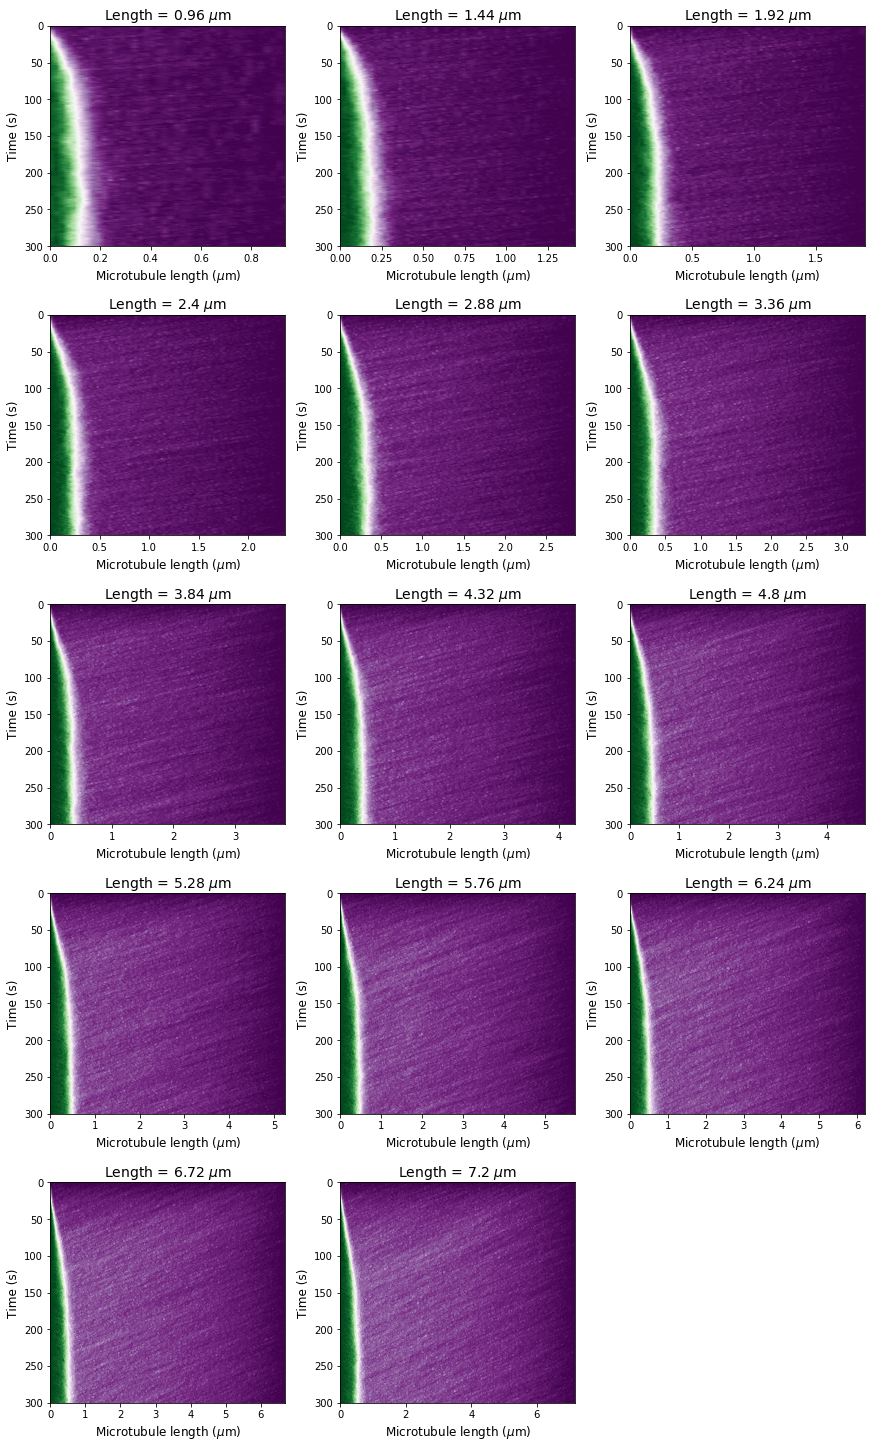

In [10]:
# Number of plots
if simPa.scan:
    num_scans = len(simPa.scan_range)
    rows = int(np.ceil(num_scans/3))
    cols = num_scans if num_scans < 3 else 3 
else:
     rows = cols = 1
        
# Setup figure
fig = plt.figure(constrained_layout=True, figsize=(cols*4 ,rows*4))
spec = fig.add_gridspec(ncols=cols, nrows=rows)

fig_num = 0
for row in range(rows):
    for col in range(cols):         
        if fig_num < len(simPa.scan_range):
            
            # Filter specific lattice size
            filter_length = RESULTS['Length']==simPa.scan_range[fig_num]
            lattice = RESULTS[filter_length].Lattice           

            # Prepare data
            X = np.arange(0, lattice.iloc[0].shape[1])
            X = X * (simPa.step_size/1000) # change units to um
            Y = np.arange(0, lattice.iloc[0].shape[0])
            Y = Y * simPa.frame_time # change units to seconds
            X, Y = np.meshgrid(X, Y)      
            Z_mean = np.mean(lattice, axis=0)                      
        
            # Plot data
            ax = fig.add_subplot(spec[row, col])     
            ax.contourf(np.flip(X), Y, Z_mean, 100, cmap='PRGn')    
            ax.set_ylim(Y[-1][0],0)  
            ax.set_xlabel('Microtubule length ($\mu$m)', fontsize=12)
            ax.set_ylabel('Time (s)', fontsize=12)
            
            if simPa.scan:
                ax.set_title('Length = ' + str(np.round(simPa.scan_range[fig_num]*(simPa.step_size/1000),2)) + ' $\mu$m' , fontsize=14)  
            else:
                ax.set_title('Kymograph (N = ' + str(simPa.num_sims) + ')', fontsize=14)
                
            fig_num += 1
        
# Save plot
if simPa.record_data:
    filename = foldername + "/" + 'Figure_1'
    plt.savefig(filename+'.eps', format='eps', dpi=1200)
    plt.savefig(filename+'.png', format='png', dpi=300)
    
plt.show()